In [18]:
# import overpy
# import json

# def extract_service_locations(bbox):
#     # Define the query
#     query = """
#     (
#         node["shop"="supermarket"]({bbox});
#         node["shop"="grocery"]({bbox});
#         node["shop"="pharmacy"]({bbox});
#         node["amenity"="police"]({bbox});
#     );
#     out;
#     """

#     # Create an instance of the Overpass API
#     api = overpy.Overpass()

#     # Execute the query
#     result = api.query(query.format(bbox=bbox))

#     # Process the retrieved data
#     service_locations = []
#     for node in result.nodes:
#         name = node.tags.get("name", "N/A")
#         latitude = node.lat
#         longitude = node.lon
#         service_locations.append({
#             "name": name,
#             "latitude": latitude,
#             "longitude": longitude
#         })

#     return service_locations

# # Specify the bounding box coordinates (adjust as per your desired area)
# y_max, x_min = -36.818, -73.077
# y_min, x_max = -36.851, -73.05
# bbox = f"bbox: <{x_min}>, <{y_min}>, <{x_max}>, <{y_max}>"

# # Extract the service locations
# locations = extract_service_locations(bbox)

# # Print the extracted service locations
# for location in locations:
#     print("Name:", location["name"])
#     print("Latitude:", location["latitude"])
#     print("Longitude:", location["longitude"])
#     print("-------------------------")


In [1]:
import sys
sys.path.append('..')
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import my_functions as mf
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = 'C:\\Users\\dalex\\Documents\\Citylab\\datos\\Procesados\\OSM_Points\\OSM_Points.shp'
gdf = gpd.read_file(path)
gdf.columns

Index(['osm_id', 'code', 'fclass', 'name', 'geometry'], dtype='object')

In [3]:
main_categories = {
  "Cuidados": ['clinic','dentist','hospital','pharmacy','doctors'],
  "Educacion": ['college','library','kindergarten','school','university'],
  "Aprovisionamiento": ['butcher','greengrocer','vending_machine','supermarket'],
  "Entretenimiento": ['attraction','artwork','arts_centre','bar','cinema','chalet','community_centre','park','nightclub','museum','monument','playground','pub','ruins','viewpoint','travel_agent','theatre','theme_park'],
  "Transporte publico": [],
  "Comercio": ['bakery','bicycle_shop','beverages','beauty_shop','bookshop','car_dealership','clothes','computer_shop','doityourself','department_store','florist','gift_shop','furniture_shop','kiosk','jeweller','mobile_phone_shop','market_place','mall','sports_shop','shoe_shop','vending_any','stationery'],
  "Servicios": ['bank','atm','camera_surveillance','car_wash','drinking_water','fire_station','laundry','hotel','veterinary','hostel','hairdresser','guesthouse','optician','motel','post_office','police','recycling','sports_centre','toilet','tourist_info','telephone'],
  "Comida para servir": ['cafe','food_court','fast_food','restaurant'],
  "Otros": ['pitch','recycling_glass','wayside_cross','bench','chemist','comms_tower','courthouse','convenience','general','fountain','memorial','prison','water_tower','waste_basket','tower','embassy'],
}

In [4]:
import pandas as pd

def assign_category(row, main_categories):
    for category, classes in main_categories.items():
        if row['fclass'] in classes:
            return category
    return None

# Ejemplo de uso
gdf['Category'] = gdf.apply(lambda row: assign_category(row, main_categories), axis=1)

In [5]:
gdf['source'] = 'OpenStreetMaps'
gdf['id'] = gdf['osm_id']
gdf['type'] = 'facilities'
gdf['Subcategory'] = gdf['fclass']
cols = ['id', 'source', 'type', 'name', 'Category', 'Subcategory', 'geometry']
display(gdf[cols].head(3))

,id,source,type,name,Category,Subcategory,geometry
0,867951484,OpenStreetMaps,facilities,SalcoBrand,Cuidados,pharmacy,POINT (-73.04903 -36.82583)
1,867951784,OpenStreetMaps,facilities,Farmacias SalcoBrand,Cuidados,pharmacy,POINT (-73.05886 -36.78982)
2,867952325,OpenStreetMaps,facilities,SalcoBrand,Cuidados,pharmacy,POINT (-73.04983 -36.82614)


In [6]:
path = 'C:\\Users\\dalex\\Documents\\Citylab\\datos\\Bases de datos nuevas\\GTFS\\Paraderos_2019.shp'
x = gpd.read_file(path)
x['id'] = x['stop_id']
x['source'] = 'GTFS'
x['type'] = 'transportation'
x['name'] = x['stop_name']
x['Category'] = "Transporte publico"
x['Subcategory'] = "bus_stop"
display(x.head(3))

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_t,parent_sta,stop_timez,wheelchair,geometry,id,source,type,name,Category,Subcategory
0,35710,NaN,Irarrazaval - Gral Novoa,NaN,-36.814930,-73.030991,NaN,NaN,0,NaN,NaN,0,POINT (-73.03099 -36.81493),35710,GTFS,transportation,Irarrazaval - Gral Novoa,Transporte publico,bus_stop
1,39624,NaN,Freire - Castellón,NaN,-36.824163,-73.047865,NaN,NaN,0,NaN,NaN,0,POINT (-73.04786 -36.82416),39624,GTFS,transportation,Freire - Castellón,Transporte publico,bus_stop
2,49309,NaN,Arturo Prat - San Martín,NaN,-36.832478,-73.057118,NaN,NaN,0,NaN,NaN,0,POINT (-73.05712 -36.83248),49309,GTFS,transportation,Arturo Prat - San Martín,Transporte publico,bus_stop


In [7]:
df = pd.concat([gdf[cols], x[cols]])

In [10]:
df.to_file('C:\\Users\\dalex\\Documents\\Citylab\\codigos\\ciudad_en_quince_min\\output\\lugares_de_interes.shp')

In [26]:
lat_min = -36.82
lat_max = -36.81
lon_min = -73.05
lon_max = -73.04
def filtrar_por_coordenadas(gdf, lat_min, lat_max, lon_min, lon_max):
    """
    Filtra un GeoDataFrame en base a los valores mínimos y máximos de latitud y longitud.

    Args:
        gdf (geopandas.GeoDataFrame): GeoDataFrame a filtrar.
        lat_min (float): Valor mínimo de latitud.
        lat_max (float): Valor máximo de latitud.
        lon_min (float): Valor mínimo de longitud.
        lon_max (float): Valor máximo de longitud.

    Returns:
        geopandas.GeoDataFrame: GeoDataFrame filtrado.
    """
    filtro_lat = (gdf.geometry.y >= lat_min) & (gdf.geometry.y <= lat_max)
    filtro_lon = (gdf.geometry.x >= lon_min) & (gdf.geometry.x <= lon_max)
    gdf_filtrado = gdf[filtro_lat & filtro_lon]
    return gdf_filtrado
df = pd.concat([gdf[cols], x[cols]])
df = filtrar_por_coordenadas(df, lat_min, lat_max, lon_min, lon_max)

In [27]:
import numpy as np
from shapely.geometry import Polygon
# Define el tamaño de la celda (ajústalo según tus necesidades)
n_celdas = 50

# Calcula los límites de la cuadrícula
xmin, ymin, xmax, ymax = lon_min, lat_min, lon_max, lat_max
x_range = np.linspace(xmin, xmax, n_celdas)
y_range = np.linspace(ymin, ymax, n_celdas)

# Genera los cuadrantes
cuadrantes = []
for i in range(len(x_range)-1):
    for j in range(len(y_range)-1):
        cuadrante = gpd.GeoDataFrame(geometry=[Polygon([(x_range[i], y_range[j]), (x_range[i+1], y_range[j]), 
                                                       (x_range[i+1], y_range[j+1]), (x_range[i], y_range[j+1])])])
        cuadrantes.append(cuadrante)

# Crea un GeoDataFrame con los cuadrantes
cuadrantes_gdf = gpd.GeoDataFrame(pd.concat(cuadrantes, ignore_index=True))
idx = cuadrantes_gdf.index
cuadrantes_gdf['idx'] = idx
cuadrantes_gdf = cuadrantes_gdf.set_crs(df.crs)

puntos_cuadrantes = gpd.GeoDataFrame(data=idx, columns=['idx'], geometry=cuadrantes_gdf.geometry.centroid)
puntos_cuadrantes = puntos_cuadrantes.set_crs(df.crs)

# # Realiza una intersección espacial entre los cuadrantes y el polígono
# # Para que considere los cuadrantes que tienen un poco de interseccion con el df
# cuadrantes_interseccion = gpd.overlay(df, cuadrantes_gdf, how='intersection', keep_geom_type=False)
# # # Para que considere solo aquellos que su centroide está dentro del df
# # cuadrantes_interseccion = gpd.overlay(df, puntos_cuadrantes, how='intersection', keep_geom_type=False)
# cuadrantes_interseccion = cuadrantes_interseccion.set_crs(df.crs)

# cuadrantes_gdf = cuadrantes_gdf[cuadrantes_gdf.idx.isin(cuadrantes_interseccion.idx)]

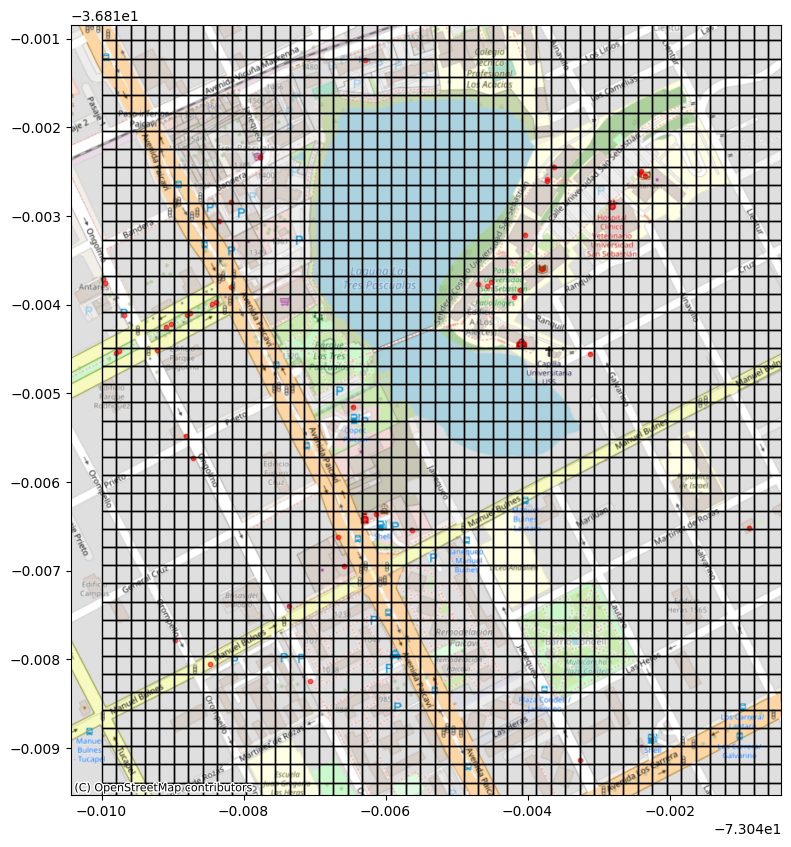

In [28]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10))
df[df['Category'] != "Transporte publico"].plot(ax=ax, markersize=10, color='red', alpha=0.6)
ctx.add_basemap(ax=ax, crs=df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
cuadrantes_gdf.plot(ax=ax, facecolor='none', edgecolor='black')
plt.show()


In [29]:
import geopandas as gpd
import pandas as pd
from geopy.distance import geodesic
import contextily as ctx
import osmnx as ox
import networkx as nx

def calcular_distancia_ruta(graph, origen, destino):
    """
    Calcula la distancia total de la ruta más corta entre un punto de origen y un punto de destino.

    Args:
        origen (tuple): Coordenadas del punto de origen (lon, lat).
        destino (tuple): Coordenadas del punto de destino (lon, lat).

    Returns:
        float: Distancia total de la ruta más corta en metros.
    """
    # Obtener los nodos más cercanos a los puntos de origen y destino
    orig = ox.distance.nearest_nodes(graph, X=origen[0], Y=origen[1])
    dest = ox.distance.nearest_nodes(graph, X=destino[0], Y=destino[1])

    # Calcular la ruta más corta
    route = ox.shortest_path(graph, orig, dest, weight="length")

    # Obtener los atributos de los bordes a lo largo del camino
    edge_attributes = ox.utils_graph.get_route_edge_attributes(graph, route, "length")

    # Calcular la distancia total sumando las longitudes de los bordes
    total_distance = sum(edge_attributes)

    return total_distance

sel_graph = 'walk'
place_name = "Concepción, Chile"

graph = ox.graph_from_place(
    place_name,
    network_type=sel_graph,
    simplify=True,
)

gdf1 = cuadrantes_gdf.copy()
gdf2 = df.copy()

# 1. Obtener el centroide de cada cuadrante en gdf1
gdf1['centroid'] = gdf1['geometry'].centroid

output = []
# 2. Iterar por cada cuadrante en gdf1
for idx, row in gdf1.iterrows():
    centroide_cuadrante = row['centroid']
    print(row['idx'])
    # 3. Filtrar gdf2 por cada categoría
    puntos_filtrados = pd.DataFrame()
    for categoria in gdf2['Category'].unique():
        puntos_categoria = gdf2[gdf2['Category'] == categoria].copy()

        # 1. Calcular la distancia desde el centroide del cuadrante a cada punto de interés
        puntos_categoria['distance'] = puntos_categoria['geometry'].apply(
            lambda point: geodesic(centroide_cuadrante.coords[0], point.coords[0]).meters
        )

        # 2. Ordenar gdf2 según la distancia ascendente
        puntos_categoria.sort_values(by='distance', inplace=True)

        # 3. Filtrar los primeros 3 registros por categoría
        puntos_categoria = puntos_categoria.head(3)

        puntos_filtrados = puntos_filtrados.append(puntos_categoria)

    # puntos_filtrados = pd.concat(puntos_filtrados)

    # 4. Calcular la distancia desde el centroide del cuadrante a cada punto filtrado utilizando contextily
    # puntos_filtrados['distance'] = puntos_filtrados['geometry'].apply(
    #     lambda point: geodesic(centroide_cuadrante.coords[0], (point.x, point.y)).meters
    # )
    
    puntos_filtrados['distance'] = puntos_filtrados['geometry'].apply(
        lambda point: calcular_distancia_ruta(graph, centroide_cuadrante.coords[0], (point.x, point.y))
    )

    # 5. Seleccionar el punto más cercano por categoría
    punto_mas_cercano = puntos_filtrados.groupby('Category')['distance'].idxmin()
    puntos_seleccionados = puntos_filtrados.loc[punto_mas_cercano]
    puntos_seleccionados['origen_id'] = row['idx']
    # Realizar operaciones adicionales con los puntos seleccionados por cuadrante
    output.append(puntos_seleccionados)


KeyboardInterrupt: 

In [ ]:
output = pd.concat(output)

In [ ]:
categories_weight = {
  "Cuidados": 0.15,
  "Educacion": 0.15,
  "Aprovisionamiento": 0.15,
  "Entretenimiento": 0.05,
  "Transporte publico": 0.2,
  "Comercio": 0.15,
  "Servicios": 0.1,
  "Comida para servir": 0.05,
  "Otros": 0,
}

categories_cols = ['Category', 'weight']

dfw = pd.DataFrame(columns=categories_cols)
for idx, (key, value) in enumerate(categories_weight.items()):
    dfw.loc[idx, 'Category'] = key
    dfw.loc[idx, 'weight'] = value


In [ ]:

def calcular_tiempo(distancia_metros):
    velocidad_kph = 6

    # Convertir la velocidad a metros por minuto
    velocidad_mpm = velocidad_kph * 1000 / 60
    
    # Calcular el tiempo en minutos
    tiempo = (distancia_metros / velocidad_mpm)
    
    return tiempo

# df['travel_time'] = df['distance'].apply(calcular_tiempo)

In [ ]:
output['travel_time'] = output['distance'].apply(calcular_tiempo)

In [ ]:
output = pd.merge(output, dfw, on='Category')

In [ ]:
output['weighted_travel_time'] = output['travel_time']*output['weight']

In [ ]:
try:
    output.to_file('output\\uss_eqm.shp')
except:
    output = gpd.read_file('output\\uss_eqm.shp')

In [ ]:
group_cols = ['origen_id']
agg_cols = ['weighted_travel_time']
map_gdf = output[group_cols+agg_cols].groupby(group_cols)[agg_cols].agg('sum').reset_index()
map_gdf = pd.merge(cuadrantes_gdf.rename(columns={'idx': 'origen_id'}), map_gdf)

In [36]:
path = 'output\\uss_en_quince_minutos.shp'
try:
    map_gdf.to_file(path)
except:
    map_gdf = gpd.read_file(path)

In [1]:
import matplotlib.pyplot as plt
import contextily as ctx

sel_graph = 'walk'
place_name = "Concepción, Chile"

graph = ox.graph_from_place(
    place_name,
    network_type=sel_graph,
    simplify=True,
)

# Trama la geometría con el facecolor según el atributo
# Genera un mapa de colores inferno
cmap = plt.cm.inferno

# Invierte los colores del cmap
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(10, 10))
map_gdf.plot(ax=ax, column='weighted_time_travel', cmap=cmap_reversed, edgecolor='gray', alpha=0.5)

# Agrega un mapa de fondo utilizando contextily
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs=map_gdf.crs.to_string(),
    alpha=1
)
ox.graph_to_gdfs(graph, nodes=False).plot(ax=ax, edgecolor='green')
# Agrega una barra de colores en la figura
sm = plt.cm.ScalarMappable(cmap=cmap_reversed)
sm.set_array(map_gdf['weighted_time_travel'])
cbar = fig.colorbar(sm)

# Personaliza la barra de colores
cbar.set_label('Travel Time')

xmin, ymin, xmax, ymax = lon_min, lat_min, lon_max, lat_max

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()

NameError: name 'ox' is not defined

In [3]:
import geopandas as gpd

grid = gpd.read_file('./input/Grilla_100_CCP_Urbano_final')
grid.shape

(4212, 2)